## **Assignment 2**  
**02805 Social Graphs & Interactions**  

**Group 13** 
- Anna Bøgevang Ekner (s193396)
- Morten Møller Christensen (s204258)


**Feedback from Assignment 1**
- Don't scale the axes of the distributions (especially not x-axis), because we distort the distributions and will arrive to wrong conclusions. He said our in- and out-degree distributions look kinda weird and not how they would expect. 
- Instead of using plt.hist, bin the data as described in the Week 2 notebook and then plot with plt.bar. Make sure that when we do comparisons of distributions, the data should be binned in the same way. 

In [269]:
import re
import json
import nltk
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from nltk.stem import WordNetLemmatizer
from fa2_modified import ForceAtlas2

sns.set_style('darkgrid')
sns.set(font_scale=1.)

# **Part 1: Genres and communities and plotting**

### **Loading and pre-processing the undirected graph**

In [212]:
def load_data():
    """
    Load the artist genre data and the undirected country musician graph

    Returns
        artist_genres_dict: dictionary of artist genres (dict)
        country_performer_undir_graph: undirected graph of country musicians (nx.Graph)
    """
    # Load the artist genre data
    artist_genres = open('artists_genres_dictionary.txt', 'r')
    raw_data = artist_genres.read() 

    # Convert into dictionary
    artist_genres_dict = eval(raw_data)

    # Load the undirected graph from the json file
    with open('undirected_graph.txt', 'r', encoding='utf-8') as f:
        undirected_graph_json = json.load(f)

    undirected_graph_data = json.loads(undirected_graph_json)
    country_performer_undir_graph = nx.node_link_graph(undirected_graph_data)

    return artist_genres_dict, country_performer_undir_graph

artist_genres_dict, country_performer_undir_graph = load_data()


Delete the cell below:

In [213]:
# Check the counts of each genre (value) in the artist_genres_dict
genres = list(artist_genres_dict.values())
genres_flat = [x for xs in genres for x in xs]
values, counts = np.unique(genres_flat, return_counts=True)
not_one = (counts != 1).sum()
# print(not_one)
# print(values)

# Dictionary of genre and their counts
genre_counts = dict(zip(values, counts))

# sort after highest values
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))
print(genre_counts)

{'country': 1499, 'folk': 178, 'country rock': 171, 'americana': 157, 'pop': 157, 'bluegrass': 129, 'rock': 116, 'country pop': 109, 'gospel': 96, 'rockabilly': 80, 'blues': 79, 'alternative country': 73, 'folk rock': 60, 'southern rock': 51, 'rock and roll': 50, 'outlaw country': 40, 'country music': 36, 'pop rock': 35, 'jazz': 34, 'soft rock': 34, 'progressive country': 31, 'roots rock': 29, 'neotraditional country': 27, 'western swing': 27, 'blues rock': 24, 'honky-tonk': 23, 'soul': 23, 'alternative rock': 20, 'texas country': 20, 'western': 20, 'hard rock': 19, 'progressive bluegrass': 17, 'country folk': 15, 'red dirt': 15, 'traditional pop': 15, 'nashville sound': 14, 'old-time': 14, 'country rap': 12, 'honky tonk': 12, 'indie rock': 12, 'bakersfield sound': 11, 'christian': 11, 'hip hop': 11, 'ccm': 10, 'indie folk': 10, 'heartland rock': 9, 'old-time music': 9, 'adult contemporary': 8, 'alt-country': 8, 'ameripolitan': 8, 'countrypolitan': 8, 'jam band': 8, 'southern gospel': 

In [214]:
def preprocess_graph(artist_genres_dict, country_performer_undir_graph):
    """ 
    Preprocess the graph by keeping only the nodes that have genre information, 
    and also remove the article_length attribute from all nodes.

    Args
        artist_genres_dict: dictionary of artist genres (dict)
        country_performer_undir_graph: undirected graph of country musicians (nx.Graph)

    Returns
        artist_undirected_graph: preprocessed undirected graph of country musicians (nx.Graph)
    """
    # Keep only the nodes that have genre information
    artist_undirected_graph = country_performer_undir_graph.copy()

    for node in list(country_performer_undir_graph.nodes()):

        # Remove the article_length attribute
        if 'article_length' in artist_undirected_graph.nodes[node]:
            del artist_undirected_graph.nodes[node]['article_length']

        if node.replace('_', ' ') not in artist_genres_dict:
            artist_undirected_graph.remove_node(node)

    return artist_undirected_graph

artist_undirected_graph_preprocessed = preprocess_graph(artist_genres_dict, country_performer_undir_graph)

print(f'Artist genre dictionary')
print(f'\tNumber of artists: {len(artist_genres_dict)}\n')

print(f'Artist graph (undirected)')
print(f'\tNumber of nodes: {artist_undirected_graph_preprocessed.number_of_nodes()}')
print(f'\tNumber of edges: {artist_undirected_graph_preprocessed.number_of_edges()}')

Artist genre dictionary
	Number of artists: 1833

Artist graph (undirected)
	Number of nodes: 1833
	Number of edges: 13943


### **Exercise 1.1: Genres and modularity**

Write about genres and modularity. 

See Network Science, Section 9.4, and reference it with: [[Network Science, Section 9.4]](https://networksciencebook.com/chapter/9#modularity) 

Mention Equation (9.12): 

\begin{equation}
M = \sum\limits^{n_c}_{c=1} \left[ \dfrac{L_c}{L} - \left(\dfrac{k_c}{2L}\right)^2 \right], \quad (\text{Equation } 9.12)
\end{equation}

where $L$ is the number of links in the network, $n_c$ is the number of communities in the partition, while $L_c$ and $k_c$ are the number of links and total degree of the nodes, respectively, for the community $c$. 

### **Exercise 1.2: Detecting communities and the value of modularity in comparison to the genres**

Detect the communities, discuss the value of modularity in comparison to the genres. 

In [215]:
def add_genre_attribute(artist_genres_dict, artist_undirected_graph, selection_method = 'first'):
    """
    Add the genre attribute to the nodes in the graph, either by selecting the 
    first genre in the list or by selecting the first genre that is not 'country'.

    Args
        artist_genres_dict: dictionary of artist genres (dict)
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        selection_method: method to select the genre, either 'first' or 'not_country' (str)

    Returns
        artist_undirected_graph: undirected graph of country musicians with genre attribute (nx.Graph)
    """

    for node in list(artist_undirected_graph.nodes()):

        # Get the genres of the artist
        genres = artist_genres_dict[node.replace('_', ' ')]

        # Select the genre based on the selection method
        if selection_method == 'first':
            genre = genres[0]

        elif selection_method == 'not_country':

            # If the artist has only one genre, select it
            if len(genres) == 1:
                genre = genres[0]

            # If the artist has multiple genres, select the first genre that is not 'country'
            else:
                genre = [g for g in genres if g != 'country'][0]
        
        # Add the genre attribute to the node
        artist_undirected_graph.nodes[node]['genre'] = genre

    return artist_undirected_graph

def find_communities_genres(artist_undirected_graph):
    """
    Find the communities in the graph, i.e. groups of nodes that share the same genre.
    Each node is characterized by the first genre in its list of genres.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """

    # Get all genres present in the graph
    all_genres = set(nx.get_node_attributes(artist_undirected_graph, 'genre').values())

    # Dictionary for the communities with each genre as key
    communities = {genre: [] for genre in all_genres}

    for node in artist_undirected_graph.nodes():

        # Get genre of the node
        genre = artist_undirected_graph.nodes[node]['genre']

        # Add the node to the corresponding community
        communities[genre].append(node)

    return communities

def compute_modularity(artist_undirected_graph, communities):
    """
    Compute the modularity of the graph, i.e. the strength of the partition of the graph into communities.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        communities: dictionary of communities (dict)

    Returns
        modularity: modularity of the graph (float)
    """

    L = artist_undirected_graph.number_of_edges()  # Total number of links in the graph
    n_c = len(communities)                         # Number of communities
    community_modularities = np.zeros(n_c)         # Array for storing the modularity values of each community
    
    for i, c in enumerate(communities.keys()):
        
        # Number of links in the community
        L_c = artist_undirected_graph.subgraph(communities[c]).number_of_edges()

        # Sum of the degrees of the nodes in the community
        k_c = np.sum([artist_undirected_graph.degree[node] for node in communities[c]])

        # Modularity value for the community
        community_modularities[i] = L_c / L - (k_c / (2 * L))**2

    # Modularity of the partition
    modularity = np.sum(community_modularities)

    return modularity

**Communities and modularity when each artist is characterized by their first genre**

In [216]:
# Add the genre attribute to the nodes in the graph (selecting the first genre)
artist_undirected_graph = add_genre_attribute(artist_genres_dict, artist_undirected_graph_preprocessed, selection_method = 'first')

# Find communities in the graph based on genre
communities = find_communities_genres(artist_undirected_graph)

# Compute the modularity of the partition
modularity = compute_modularity(artist_undirected_graph, communities)

print(f'Partion of the artist graph based on genre')
print(f'\tSelection method: first genre')
print(f'\tNumber of communities: {len(communities)} communities')
print(f'\tLargest community: {max([len(communities[genre]) for genre in communities])} artists')
print(f'\tSmallest community: {min([len(communities[genre]) for genre in communities])} artist')
print(f'\tModularity: {modularity:.4f}')

Partion of the artist graph based on genre
	Selection method: first genre
	Number of communities: 112 communities
	Largest community: 1221 artists
	Smallest community: 1 artist
	Modularity: 0.0713


**Communities and modularity when each artist is characterized by their first genre that is not `country`**

In [217]:
# Add the genre attribute to the nodes in the graph (selecting the first genre that is not 'country')
artist_undirected_graph = add_genre_attribute(artist_genres_dict, artist_undirected_graph_preprocessed, selection_method = 'not_country')

# Find communities in the graph based on genre
communities = find_communities_genres(artist_undirected_graph)

# Compute the modularity of the partition
modularity = compute_modularity(artist_undirected_graph, communities)

print(f'Partion of the artist graph based on genre')
print(f'\tSelection method: first genre that is not "country"')
print(f'\tNumber of communities: {len(communities)} communities')
print(f'\tLargest community: {max([len(communities[genre]) for genre in communities])} artists')
print(f'\tSmallest community: {min([len(communities[genre]) for genre in communities])} artist')
print(f'\tModularity: {modularity:.4f}')

Partion of the artist graph based on genre
	Selection method: first genre that is not "country"
	Number of communities: 141 communities
	Largest community: 765 artists
	Smallest community: 1 artist
	Modularity: 0.0842


In [218]:
def find_communities_louvain(artist_undirected_graph):
    """
    Find the communities in the graph using the Louvain algorithm.

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """
    # Run Louvain algorithm
    communities_louvain = nx.community.louvain_communities(artist_undirected_graph, seed = 0)

    # Dictionary for the communities with each genre as key
    communities = {}

    for i, community in enumerate(communities_louvain):
        
        # Add each artist in the community to the dictionary
        communities[i] = list(community)
    
    return communities

def find_communities_genres_all(artist_genres_dict):
    """ 
    Find the communities in the graph, where each node is characterized by all of the genres in its list of genres.

    Args
        artist_genres_dict: dictionary of artist genres (dict)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """
    
    # Get all unique values from the dictionary
    all_genres = set([genre for genres in artist_genres_dict.values() for genre in genres])

    # Dictionary for the communities with each genre as key
    communities = {genre: [] for genre in all_genres}

    for artist in artist_genres_dict.keys():
        
        # Get the genres of the artist
        genres = artist_genres_dict[artist]

        for genre in genres:
            communities[genre].append(artist.replace(' ', '_'))

    return communities

In [219]:
# Find communities in the graph based on genre (selecting all genres for each artist)
communities_genres_all = find_communities_genres_all(artist_genres_dict)

# Find communities in the graph based on Louvain algorithm
communities_louvain = find_communities_louvain(artist_undirected_graph)

# Compute the modularity of the partition (Louvain)
modularity = compute_modularity(artist_undirected_graph, communities_louvain)

print(f'Partion of the artist graph based on Louvain algorithm')
print(f'\tNumber of communities: {len(communities_louvain)} communities')
print(f'\tLargest community: {max([len(communities_louvain[i]) for i in communities_louvain])} artists')
print(f'\tSmallest community: {min([len(communities_louvain[i]) for i in communities_louvain])} artist')
print(f'\tModularity: {modularity:.4f}')

Partion of the artist graph based on Louvain algorithm
	Number of communities: 12 communities
	Largest community: 476 artists
	Smallest community: 1 artist
	Modularity: 0.3932


To-do:

- Find Louvain communities with `communities` library (or use `networkx.communities.louvain_communities`), and compute modularity. 


### **Exercise 1.3: Calculating the matrix $D$ and discussing the findings**

In [220]:
def get_n_most_common_communities(community_dict, n=1):
    """
    Get the n most common communities in the community dictionary
    
    Args
        community_dict: dictionary of communities (dict)
        n: number of most common communities to return (int)
        
    Returns
        most_common_communities: list of the n most common communities (list)
        community_to_artists: dictionary of genres to artists (dict)
    """

    genre_counts = {genre: len(community_dict[genre]) for genre in community_dict}
    most_common_communities = sorted(genre_counts, key=genre_counts.get, reverse=True)[:n]

    community_to_artists = {genre: community_dict[genre] for genre in most_common_communities}
    

    return community_to_artists

communities_louvain_common = get_n_most_common_communities(communities_louvain, n=7)
communities_genres_all_common = get_n_most_common_communities(communities_genres_all, n=7)
communities_genres_not_country_as_first_common = get_n_most_common_communities(communities, n=7)

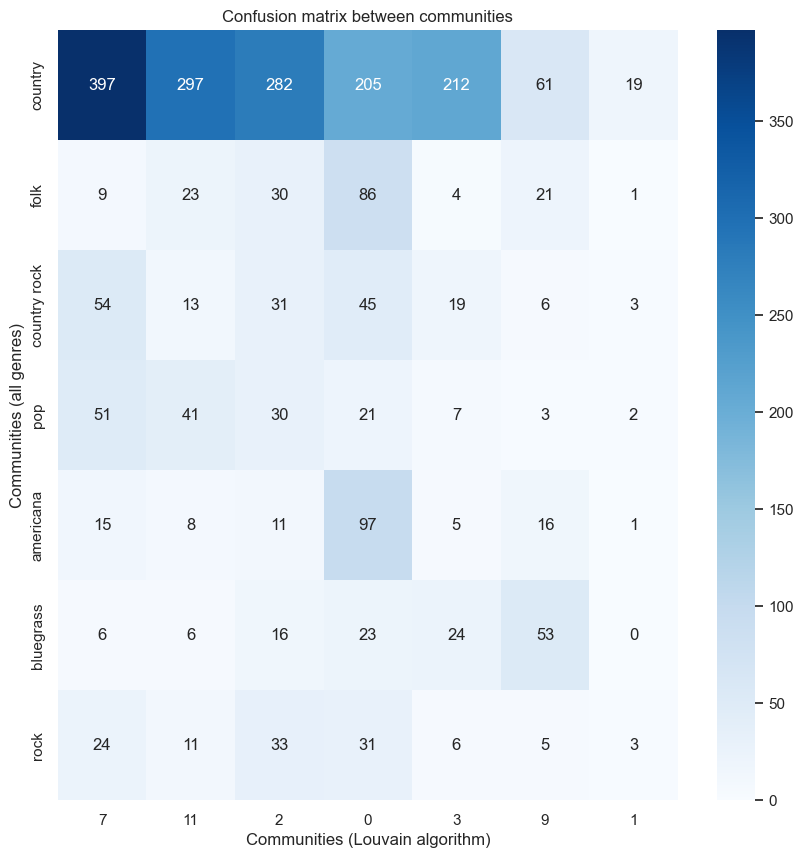

In [221]:
def create_confusion_matrix(communities_louvain_common, communities_genres_all_common):
    """
    Create a confusion matrix between the communities found by the Louvain algorithm and the communities based on all genres

    Args
        communities_louvain_common: dictionary of communities found by Louvain algorithm (dict)
        communities_genres_all_common: dictionary of communities based on all genres (dict)

    Returns
        confusion_matrix: confusion matrix between the communities (np.array)
    """

    confusion_matrix = np.zeros((len(communities_louvain_common), len(communities_genres_all_common)))
    for i, genre_louvain in enumerate(communities_louvain_common): 
        for j, genre_all in enumerate(communities_genres_all_common):
            intersection = set(communities_louvain_common[genre_louvain]) & set(communities_genres_all_common[genre_all])
            confusion_matrix[j, i] = len(intersection)

    return confusion_matrix




D = create_confusion_matrix(communities_louvain_common, communities_genres_all_common)

def plot_confusion_matrix(D, communities_louvain_common, communities_genres_all_common):
    """
    Plot the confusion matrix between the communities found by the Louvain algorithm and the communities based on all genres

    Args
        D: confusion matrix between the communities (np.array)
        community_louvain_dict: dictionary of communities found by Louvain algorithm (dict)
        community_genres_all_dict: dictionary of communities based on all genres (dict)
    """

    fig, ax = plt.subplots(figsize=(10, 10))
    
    sns.heatmap(D, annot=True, fmt='g', cmap='Blues',
                xticklabels=communities_louvain_common, 
                yticklabels=communities_genres_all_common)
    
    plt.xlabel('Communities (Louvain algorithm)')
    plt.ylabel('Communities (all genres)')
    plt.title('Confusion matrix between communities')
    plt.show()

plot_confusion_matrix(D, communities_louvain_common, communities_genres_all_common)

To-do:

- Confusion matrix of comparison between genre (with `all` selection method) vs. communities, and discuss. 

### **Exercise 1.4: Plotting the communities**

To-do:

- Plot and compare communities found based on genre vs. communities found based on Louvain algorithm. 

In [222]:
def FA2_positions(artist_undirected_graph, pos, iterations=200):
    """
    Compute the ForceAtlas2 layout for the graph

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        pos: initial positions of the nodes (dict)
        iterations: number of iterations for the layout (int)

    Returns
        positions: positions of the nodes after the layout (dict)
    """
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,  
        edgeWeightInfluence=1.0,
        jitterTolerance=0.5,  
        barnesHutOptimize=True,
        barnesHutTheta=1.8,  # Lower to increase structure
        scalingRatio=1.0,  # Reduce to prevent large spread
        strongGravityMode=False,
        gravity=0.1,  # Lower to reduce overlap
        verbose=True
    )

    # Compute the layout
    positions = forceatlas2.forceatlas2_networkx_layout(artist_undirected_graph, pos=pos, iterations=iterations)

    return positions
def assign_colors_by_genre(graph, genre_dict):
    """
    Assign a unique color ID to each node in the graph based on its genre.

    Args
        graph: undirected graph of country musicians (nx.Graph)
        genre_dict: dictionary of artist genres (dict)

    Returns

        color_assignments: list of color IDs for each node in the graph (list)
    """
    color_assignments = []
    genre_to_color = {genre: index for index, genre in enumerate(genre_dict)}  # Map each genre to a unique color ID
    # print(genre_to_color)

    for node in graph.nodes():
        assigned = False
        for genre, artists in genre_dict.items():
            if node in artists:
                color_assignments.append(genre_to_color[genre])  # Assign the genre’s color ID
                assigned = True
                break
        if not assigned:
            # If the node is not in any genre, assign a default color ID, like -1
            color_assignments.append(-1)
    return color_assignments

def create_plot(artist_undirected_graph, positions, communities, cmap_name, title):
    """
    Create a plot of the artist graph colored by the communities

    Args
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        positions: positions of the nodes in the graph (dict)
        communities: dictionary of communities (dict)
        cmap_name: name of the colormap to use (str)
        title: title of the plot (str)
    """

    color_assignments = assign_colors_by_genre(artist_undirected_graph, communities)
    cmap = plt.cm.get_cmap(cmap_name, max(color_assignments) + 1)

    
    nx.draw_networkx_nodes(artist_undirected_graph, positions, node_size=10, node_color=color_assignments, cmap=cmap)
    nx.draw_networkx_edges(artist_undirected_graph, positions, alpha=0.1)
    plt.title(title)
    plt.axis('off')

100%|██████████| 200/200 [00:11<00:00, 16.68it/s]
C:\Users\annae\AppData\Local\Temp\ipykernel_9408\1802930220.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name, max(color_assignments) + 1)


BarnesHut Approximation  took  1.41  seconds
Repulsion forces  took  10.04  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  0.08  seconds
AdjustSpeedAndApplyForces step  took  0.17  seconds


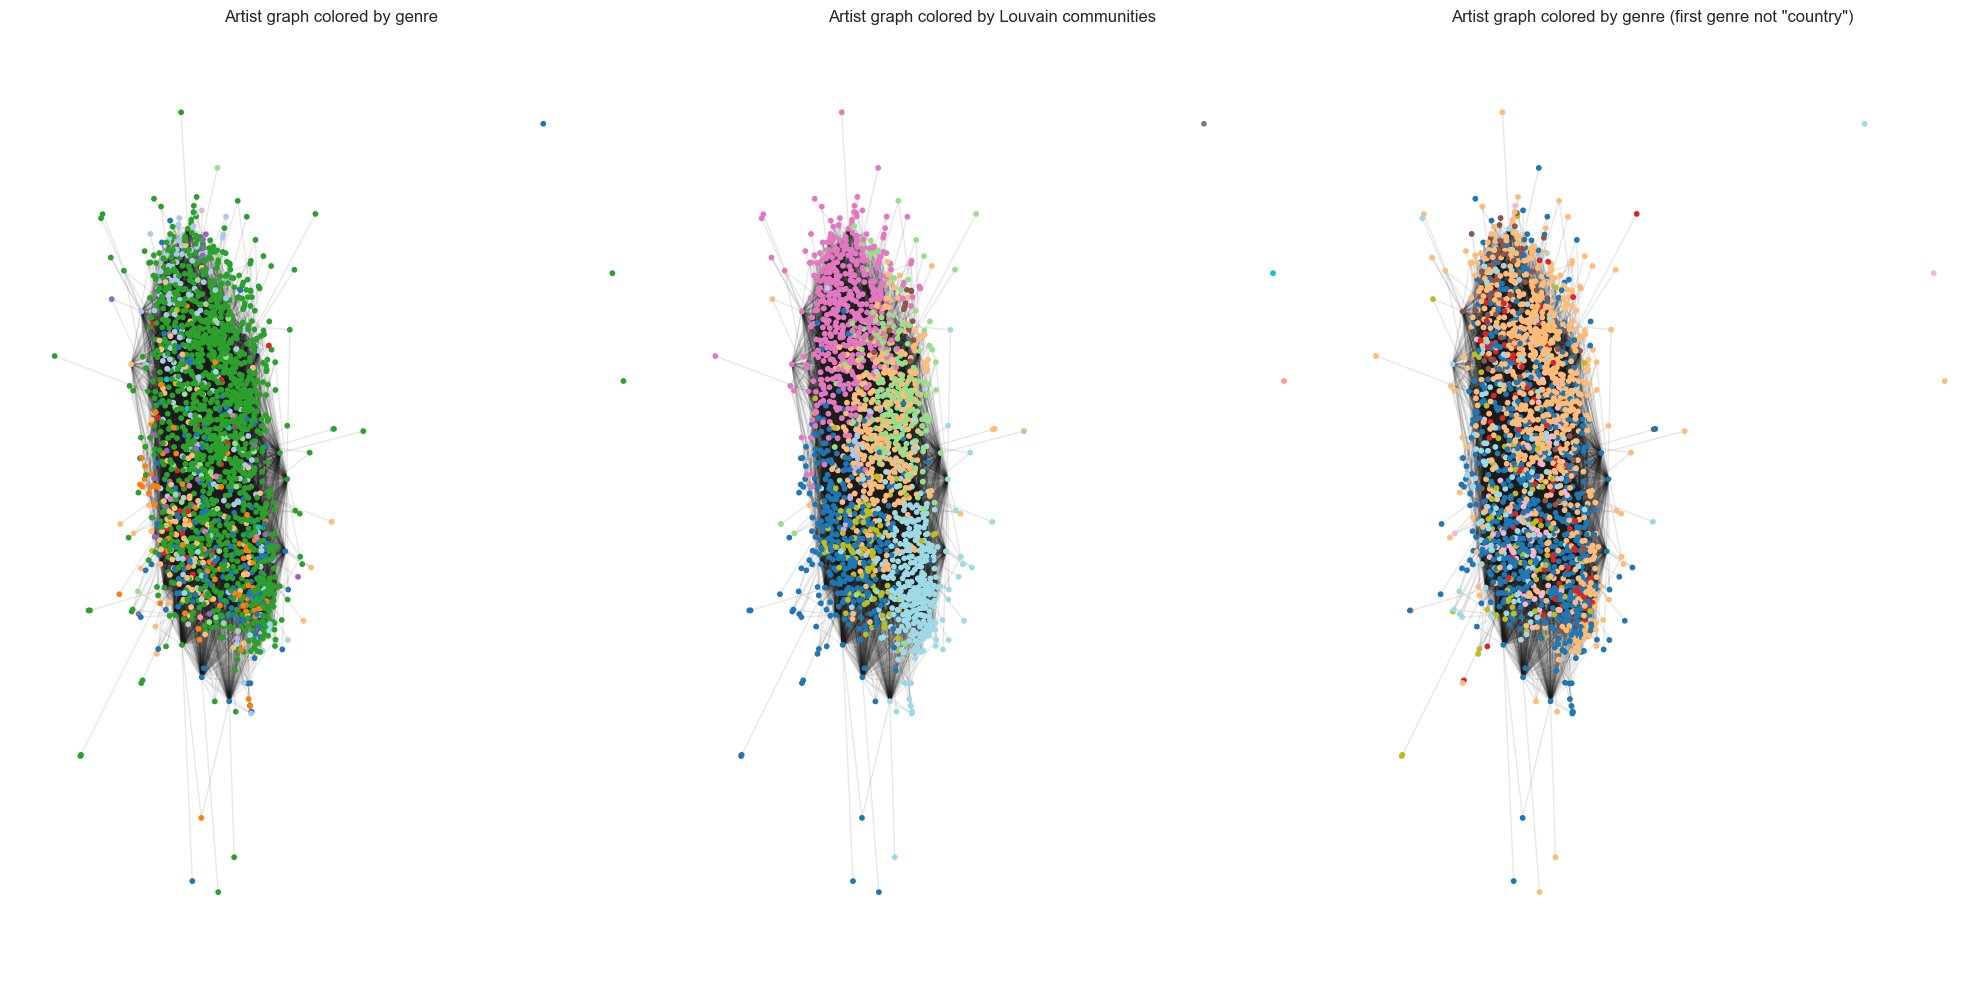

In [223]:
# Which one is the better option, try both
#positions = FA2_positions(artist_undirected_graph, pos=None, iterations=200)
initial_pos = nx.spring_layout(artist_undirected_graph)
positions = FA2_positions(artist_undirected_graph, pos=initial_pos, iterations=200)
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
create_plot(artist_undirected_graph, positions, communities_genres_all, 'tab20', 'Artist graph colored by genre')
plt.subplot(1, 3, 2)
create_plot(artist_undirected_graph, positions, communities_louvain, 'tab20', 'Artist graph colored by Louvain communities')
plt.subplot(1, 3, 3)
create_plot(artist_undirected_graph, positions, communities_genres_not_country_as_first_common, 'tab20', 'Artist graph colored by genre (first genre not "country")')
plt.tight_layout()
plt.show()

# **Part 2: TF-IDF to understand genres and communities**

### **Exercise 2.1: The concept of TF-IDF**

### **Exercise 2.2: Calculating and visualizing TF-IDF for the genres and communities**

To-do:

- Word-clouds of both genre communities and Louvain communities.

- Subplot with 6 word-clouds for each (3x2). 

### **Exercise 2.3: Discussing the difference between the word-clouds between genres and communities**

To-do:

- Discuss (using confusion matrix from previous exercise) the difference between word-clouds of genre communities and Louvain communities. Look at what the artists with a Louvain community has in common, since it is not (at least not only) based on genre?

# **Part 3: Sentiment of the artists and communities**

### **Exercise 3.1: Sentiment of the artist pages**

In [224]:
def load_wordlist():
    """
    Load the LabMT wordlist.

    Returns
        wordlist: wordlist with happiness scores (pd.DataFrame)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)
    """
    wordlist = pd.read_table("wordlist.txt")
    happiness_score_dict = wordlist.set_index('word')['happiness_average'].to_dict()

    return wordlist, happiness_score_dict

# Load the LabMT wordlist
wordlist, happiness_score_dict = load_wordlist()

In [225]:
def compute_sentiment(tokens, happiness_score_dict):
    """ 
    Compute the sentiment of a tokenized text based on the LabMT wordlist.

    Args:
        tokens: tokenized text (list)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)

    Returns:
        sentiment: average sentiment score for the tokens (float)
        words_found: number of words from the wordlist found in the text (int)
    """

    happiness_scores = []   # List to store the happiness scores of the tokens
    words_found = 0         # Number of words from the workdlist found in the text

    for token in tokens:

        # Check if the token is in the wordlist
        if token in happiness_score_dict:

            # Add the happiness score to the list, and increment the number of words found
            happiness_scores.append(happiness_score_dict[token])
            words_found += 1

    # Compute the sentiment score
    if len(happiness_scores) > 0:
        sentiment = np.mean(happiness_scores)

    else:
        sentiment = 0

    return sentiment, words_found

In [226]:
def clean_text(text):
    """
    Clean a text by removing comments, templates, file links, and square bracket links.

    Args
        text: text to clean (str)

    Returns
        clean_text: cleaned text (str)
    """

    # Remove comments, templates, file links, and square bracket links
    clean_text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)
    clean_text = re.sub(r'\{\{.*?\}\}', '', clean_text, flags=re.DOTALL)
    clean_text = re.sub(r'\[\[File:.*?\]\]', '', clean_text, flags=re.DOTALL)
    clean_text = re.split(r"==\s?Early\s?[Ll]ife\s?==", clean_text, 1)[-1]
    clean_text = re.sub(r'\[\[|\]\]', '', clean_text)
    clean_text = re.sub(r'[^\w\s]', '', clean_text)

    return clean_text

def tokenize_text(text):
    """
    Tokenize a text into words using NLTK's word_tokenize function.

    Args:
        text: clean text to be tokenized (str)

    Returns:
        tokens: tokenized text (list)
    """

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalnum()]

    # Set tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Lemmatize tokens using NLTK's WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

Some pages had sentiment score equal to 0. After investigating, found that they were all redirect pages. So these artists were removed as nodes from the graph.

In [236]:
def add_sentiment_attribute(artist_undirected_graph, happiness_score_dict):
    """
    Add the sentiment attribute to the nodes in the graph, based on the text content of the Wikipedia page.

    Args 
        artist_undirected_graph: undirected graph of country musicians (nx.Graph)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)

    Returns
        artist_undirected_graph: undirected graph of country musicians with sentiment attribute (nx.Graph)
    """

    for node in list(artist_undirected_graph.nodes()):

        # Convert to the format of the filenames
        node = node.replace('"', '')
        node = node.replace('/', '-')

        with open(f"../Assignment 1/data/{node}.txt", "r", encoding="utf-8") as f:
            raw_content = f.read()
        
        # Clean and tokenize the text
        clean_content = clean_text(raw_content)
        tokens = tokenize_text(clean_content)

        # Compute the sentiment of the text
        sentiment_score, words_found = compute_sentiment(tokens, happiness_score_dict)

        if sentiment_score > 0:
            try: 
                artist_undirected_graph.nodes[node]['sentiment_score'] = sentiment_score

            except:
                continue

        else:
            # Remove nodes with no sentiment score (because they are redirect pages)
            artist_undirected_graph.remove_node(node)

    return artist_undirected_graph

# Add the sentiment attribute to the nodes in the graph
artist_undirected_graph = add_sentiment_attribute(artist_undirected_graph, happiness_score_dict)

In [317]:
def compute_sentiment_statistics(artist_undirected_graph):
    """
    Compute the average, median, variance, 25th percentile, and 75th percentile of the sentiment scores.

    Args
        artist_undirected_graph: undirected graph of country musicians with sentiment attribute (nx.Graph)
    
    Returns 
        sentiment_statistics: sentiment statistics (dict)
    """
    # Get sentiment score of all nodes
    all_sentiment_scores = nx.get_node_attributes(artist_undirected_graph, 'sentiment_score')
    all_sentiment_scores = list(all_sentiment_scores.values())

    # Dictionary for storing the sentiment statistics
    sentiment_statistics = {}

    # Compute sentiment statistics
    sentiment_statistics['minimum'] = np.min(all_sentiment_scores)
    sentiment_statistics['maximum'] = np.max(all_sentiment_scores)
    sentiment_statistics['average'] = np.mean(all_sentiment_scores)
    sentiment_statistics['median'] = np.median(all_sentiment_scores)
    sentiment_statistics['variance'] = np.var(all_sentiment_scores)
    sentiment_statistics['percentile_25'] = np.percentile(all_sentiment_scores, 25)
    sentiment_statistics['percentile_75'] = np.percentile(all_sentiment_scores, 75)

    return sentiment_statistics

def plot_sentiment_statistics(artist_undirected_graph, sentiment_statistics):
    """
    Plot the sentiment statistics.

    Args
        sentiment_statistics: sentiment statistics (dict)
    """
    # Get sentiment score of all nodes
    all_sentiment_scores = nx.get_node_attributes(artist_undirected_graph, 'sentiment_score')
    all_sentiment_scores = list(all_sentiment_scores.values())

    # Define the bin edges with float intervals
    bin_edges = np.linspace(min(all_sentiment_scores), max(all_sentiment_scores), num=101) 

    # Bin the sentiment scores
    counts, bin_edges = np.histogram(all_sentiment_scores, bins = bin_edges)

    # Plotting the sentiment scores
    plt.figure(figsize=(10, 4))
    plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], label = 'Sentiment scores', color='C2', alpha = 0.5)
    plt.axvline(sentiment_statistics['average'], color='r', linestyle='-', label='Average')
    plt.axvline(sentiment_statistics['median'], color='C0', linestyle='-', label='Median')
    plt.axvline(sentiment_statistics['percentile_25'], color='C6', linestyle='--', label='Q1 (25th percentile)')
    plt.axvline(sentiment_statistics['percentile_75'], color='C6', linestyle='--', label='Q3 (75th percentile)')
    plt.xlabel('Sentiment score')
    plt.ylabel('Number of artists')
    plt.title('Distribution of sentiment scores for artist pages')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [319]:
# Compute sentiment statistics across all nodes
sentiment_statistics = compute_sentiment_statistics(artist_undirected_graph)

print(f'Sentiment statistics of the artist graph')
print(f'\tMinimum: {sentiment_statistics["minimum"]:.2f}')
print(f'\tMaximum: {sentiment_statistics["maximum"]:.2f}')
print(f'\tAverage: {sentiment_statistics["average"]:.2f}')
print(f'\tMedian: {sentiment_statistics["median"]:.2f}')
print(f'\tVariance: {sentiment_statistics["variance"]:.2f}')
print(f'\t25th percentile: {sentiment_statistics["percentile_25"]:.2f}')
print(f'\t75th percentile: {sentiment_statistics["percentile_75"]:.2f}')

Sentiment statistics of the artist graph
	Minimum: 4.85
	Maximum: 6.82
	Average: 5.65
	Median: 5.65
	Variance: 0.02
	25th percentile: 5.58
	75th percentile: 5.71


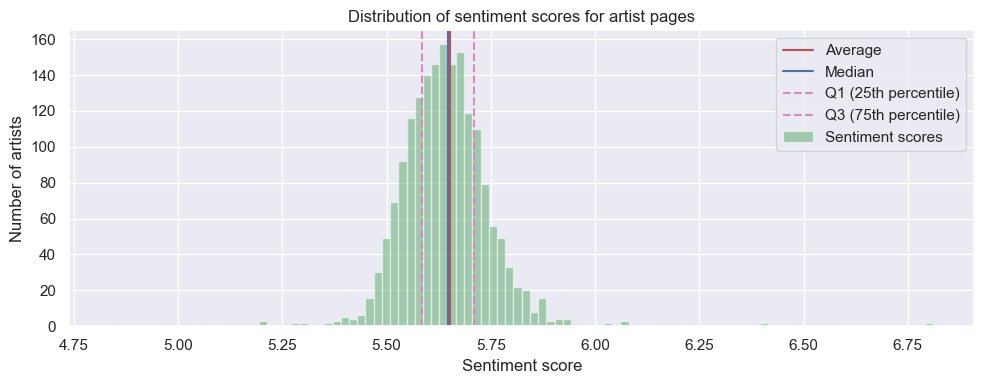

In [315]:
plot_sentiment_statistics(artist_undirected_graph, sentiment_statistics)

In [311]:
def find_top_n_pages(artist_undirected_graph, n):
    """
    Find the top pages based on the sentiment score, both the happiest and the saddest.

    Args
        artist_undirected_graph: undirected graph of country musicians with sentiment attribute (nx.Graph)
        n: number of top pages to return (int)

    Returns
        top_happiest_pages: list of n happiest pages, i.e. highest sentiment scores (list)
        top_saddest_pages: list of n saddest pages, i.e. lowest sentiment scores (list)
    """

    # Get sentiment score of all nodes
    all_sentiment_scores = nx.get_node_attributes(artist_undirected_graph, 'sentiment_score')

    # Sort the nodes based on the sentiment score
    sorted_nodes = sorted(all_sentiment_scores, key=all_sentiment_scores.get, reverse=True)

    # Get the top pages
    top_happiest_pages = sorted_nodes[:10]
    top_saddest_pages = sorted_nodes[-10:]

    return top_happiest_pages, top_saddest_pages


def display_scrollable_dataframes(df1, header1, df2, header2, max_height=500):
    """ 
    Display two pandas DataFrames side by side in a scrollable format.
    """
    
    display(HTML(f"""
    <div style="display: flex;">
        <div style="max-height: {max_height}px; overflow-y: auto; padding: 5px; width: 50%;">
            <h3>{header1}</h3>
            {df1.to_html(index=False)}
        </div>
        <div style="max-height: {max_height}px; overflow-y: auto; padding: 5px; width: 50%;">
            <h3>{header2}</h3>
            {df2.to_html(index=False)}
        </div>
    </div>
    """))

In [312]:
# Find the top happiest and saddest pages
top_happiest_pages, top_saddest_pages = find_top_n_pages(artist_undirected_graph, n=10)

# Happiest pages
happiest_df = pd.DataFrame({'Artist': top_happiest_pages, 'Sentiment': [np.round(artist_undirected_graph.nodes[page]['sentiment_score'], 2) for page in top_happiest_pages]})
happiest_df = happiest_df.sort_values(by='Sentiment', ascending=False)

# Saddest pages
saddest_df = pd.DataFrame({'Artist': top_saddest_pages, 'Sentiment': [np.round(artist_undirected_graph.nodes[page]['sentiment_score'], 2) for page in top_saddest_pages]})
saddest_df = saddest_df.sort_values(by='Sentiment', ascending=True)

# Display the tables side by side
display_scrollable_dataframes(happiest_df, 'Top 10 happiest pages', saddest_df, 'Top 10 saddest pages')

Artist,Sentiment
Ernest_(musician),6.82
Jewel_(musician),6.82
Sparx_(US_band),6.58
The_Carter_Family,6.53
Amazing_Rhythm_Aces,6.49
Lanco_(band),6.42
Frank_Hannon,6.42
Stonewall_Jackson_(musician),6.26
Boy_Howdy_(band),6.24
Allman_Brothers_Band,6.21


### **Exercise 3.2: Sentiment of the largest communities**